In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
while Path.cwd().name != 'bayesian_beats_cheats':
    os.chdir(Path.cwd().parent)
    
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix
# from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import seaborn as sns

######## TORCH ###########
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch.utils.tensorboard import SummaryWriter


######## Jon's code #########
from src import preprocess
from src.visualization import make_confusion_matrix

In [3]:
# GPU = 8,13

# gpu_list = ''
# multi_gpus=False
# if isinstance(GPU, int):
#     gpu_list = str(GPU)
# else:
#     multi_gpus = True
#     for i, gpu_id in enumerate(GPU):
#         gpu_list += str(gpu_id)
#         if i != len(GPU) - 1:
#             gpu_list += ','
#     os.environ['CUDA_VISIBLE_DEVICES'] = gpu_list
#     print(gpu_list)

device = torch.device("cuda:8" if torch.cuda.is_available() else "cpu")

In [5]:
import time
from datetime import datetime

In [8]:
!tensorboard --logdir=runs

^C
Traceback (most recent call last):
  File "/home/kenghwee/cs5340_proj/env/lib/python3.8/site-packages/tensorboard/compat/__init__.py", line 46, in tf
    from tensorboard.compat import notf  # noqa: F401
ImportError: cannot import name 'notf' from 'tensorboard.compat' (/home/kenghwee/cs5340_proj/env/lib/python3.8/site-packages/tensorboard/compat/__init__.py)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/kenghwee/cs5340_proj/env/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/home/kenghwee/cs5340_proj/env/lib/python3.8/site-packages/tensorboard/main.py", line 58, in run_main
    if getattr(tf, "__version__", "stub") == "stub":
  File "/home/kenghwee/cs5340_proj/env/lib/python3.8/site-packages/tensorboard/lazy.py", line 68, in __getattr__
    return getattr(load_once(self), attr_name)
  File "/home/kenghwee/cs5340_proj/env/lib/python3.8/site-packages/tensorboard/lazy.py", line 100, in wrap

## Getting mappings

In [6]:
df_node = pd.read_csv('data/imputed_unified_node_data.csv', keep_default_na=False)
df_edge = pd.read_csv('data/uniq_lines_edge_weights.csv') # change to anything else later.

# combine train and val together to train
X_train, X_val, X_test, y_train, y_val, y_test = preprocess.stratified_train_val_test_split(df_node)

### Generating y values

In [7]:
y = pd.concat([y_train, y_val, y_test]).sort_index()
y = y.apply(lambda x: 1 if x>0 else 0)

In [8]:
id2name = dict(zip(df_node.index, df_node["name"].values))

In [9]:
name2id = dict(zip(df_node["name"].values, df_node.index))

In [10]:
usable_cols = ['year_of_study',
 'participation',
 'pe_percent',
 'finals_percent',
 'midterms_percent',
 'afast',
 'level_min_max',
 'exp_min_max',
 'num_videos',
 'avg_videos_completion',
 'batch_1821',
 'batch_1935',
 'batch_2023',
 'major_-',
 'major_Business Analytics',
 'major_Chemistry',
 'major_Computational Biology',
 'major_Data Science and Analytics',
 'major_Faculty of Arts & Social Sci',
 'major_Faculty of Engineering',
 'major_Faculty of Law',
 'major_Faculty of Science',
 'major_Life Sciences',
 'major_Math/Applied Math',
 'major_NUS Business School',
 'major_Pharmacy',
 'major_Physics',
 'major_Quantitative Finance',
 'major_School of Computing',
 'major_School of Design & Environment',
 'major_Statistics',
 'major_Yong Loo Lin School (Medicine)']

### Generating features and pre-processing

In [11]:
df_node = df_node[usable_cols]

In [69]:
from sklearn import preprocessing

mm_scaler = preprocessing.MinMaxScaler()
df_node_kh = mm_scaler.fit_transform(df_node)

### Generating node masks for train, val, test split


In [70]:
train_mask = df_node.index.isin(X_train.index)
val_mask = df_node.index.isin(X_val.index)
test_mask = df_node.index.isin(X_test.index)

### Generating edge index and edge weights

In [71]:
df_edge["NodeID1_Num"] = df_edge["NodeID1"].map(name2id)
df_edge["NodeID2_Num"] = df_edge["NodeID2"].map(name2id)

In [52]:
df_edge

,NodeID1,NodeID2,edge_weights,NodeID1_Num,NodeID2_Num
0,aaron_christian,marc_key,0.476504,21,957
1,aaron_christian,joseph_trevino,0.329899,21,129
2,aaron_pope,annette_solis,0.347540,683,866
3,aaron_pope,carol_harris,0.419707,683,336
4,aaron_powell,jennifer_simmons,0.366710,437,865
...,...,...,...,...,...
3382,zachary_beasley,robert_lopez,0.481366,244,17
3383,zachary_beasley,steven_adams,0.676140,244,622
3384,zachary_carter,richard_higgins,0.362905,53,718
3385,zachary_hernandez,thomas_barnes,1.284771,958,868


In [53]:
df_edge_index = df_edge[["NodeID1_Num", "NodeID2_Num"]].values.tolist()
df_edge_weights = df_edge["edge_weights"].values.tolist()

In [54]:
reverse_edge_index = [list(reversed(x)) for x in df_edge_index]

In [55]:
lst = list(zip(df_edge_index + reverse_edge_index, df_edge_weights * 2))

In [56]:
edge_index, edge_weights = [], []
for edge, weight in lst:
    edge_index.append(edge)
    edge_weights.append(weight)

In [72]:
df_node_kh

array([[0.        , 0.7       , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.7       , 0.73333333, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.7       , 0.9       , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.74      , 0.6225    , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.74      , 0.64916667, ..., 0.        , 0.        ,
        0.        ],
       [0.11111111, 0.66      , 0.455     , ..., 0.        , 0.        ,
        0.        ]])

In [73]:
final_x = torch.tensor(df_node_kh, dtype=torch.float)
final_train_mask = torch.tensor(train_mask, dtype=torch.bool)
final_val_mask = torch.tensor(val_mask, dtype=torch.bool)
final_test_mask = torch.tensor(test_mask, dtype=torch.bool)
final_y = torch.tensor(y.values, dtype=torch.int64)
final_edge_index = torch.tensor(edge_index, dtype=torch.long)
final_edge_weights = torch.tensor(edge_weights, dtype=torch.float)

In [74]:
data = Data(x=final_x, train_mask=final_train_mask, val_mask=final_val_mask, test_mask=final_test_mask,
           y=final_y, edge_index=final_edge_index.t().contiguous(), edge_weight=final_edge_weights.t(),
           num_classes=2)

In [75]:
data = data.to(device)

### Summary statistics

In [76]:
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Number of classes: {data.num_classes}')

# put all infor in device cuda, use multiple GPUs.

Number of nodes: 1024
Number of edges: 6774
Average node degree: 6.62
Number of training nodes: 716
Training node label rate: 0.70
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True
Number of classes: 2


In [ ]:
#### Verified with CORA benchmark dataset specifications to ensure correctness.

# from torch_geometric.datasets import Planetoid
# from torch_geometric.transforms import NormalizeFeatures

# dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

# print()
# print(f'Dataset: {dataset}:')

# for key, item in dataset[0]:
#     print("{} found in data".format(key))

### Get Weight Ratio for weight labels

In [133]:
num_cheats = sum(y > 0)
label_ratio = [len(y) - num_cheats, num_cheats]

In [134]:
normWeights = [1 - (x/sum(label_ratio)) for x in label_ratio]
normWeights = torch.FloatTensor(normWeights).to(device)

## GCN Baseline
Ensure code is running properly

In [79]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, data.num_classes)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(32, 16)
  (conv2): GCNConv(16, 2)
)


### Baseline training:

In [80]:
model = GCN(hidden_channels=16).to(device)
# model = nn.DataParallel(model)

In [81]:
%matplotlib inline

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=normWeights)

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index, data.edge_weight)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index, data.edge_weight)
    pred = out.cpu().argmax(dim=1)  # Use the class with highest probability.
#     print(pred.tolist())
    test_correct = pred[data.val_mask] == data.y.cpu()[data.val_mask]  # Check against ground-truth labels.
    cf = confusion_matrix(data.y.cpu()[data.val_mask], pred[data.val_mask])
    make_confusion_matrix(cf)
    test_acc = int(test_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
    return test_acc


for epoch in range(1, 201):
    loss = train().tolist()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 0.7023
Epoch: 002, Loss: 0.6948
Epoch: 003, Loss: 0.6885
Epoch: 004, Loss: 0.6937
Epoch: 005, Loss: 0.6883
Epoch: 006, Loss: 0.6874
Epoch: 007, Loss: 0.6907
Epoch: 008, Loss: 0.6860
Epoch: 009, Loss: 0.6827
Epoch: 010, Loss: 0.6862
Epoch: 011, Loss: 0.6819
Epoch: 012, Loss: 0.6846
Epoch: 013, Loss: 0.6794
Epoch: 014, Loss: 0.6797
Epoch: 015, Loss: 0.6910
Epoch: 016, Loss: 0.6855
Epoch: 017, Loss: 0.6823
Epoch: 018, Loss: 0.6829
Epoch: 019, Loss: 0.6807
Epoch: 020, Loss: 0.6785
Epoch: 021, Loss: 0.6780
Epoch: 022, Loss: 0.6749
Epoch: 023, Loss: 0.6704
Epoch: 024, Loss: 0.6681
Epoch: 025, Loss: 0.6726
Epoch: 026, Loss: 0.6782
Epoch: 027, Loss: 0.6701
Epoch: 028, Loss: 0.6682
Epoch: 029, Loss: 0.6688
Epoch: 030, Loss: 0.6703
Epoch: 031, Loss: 0.6608
Epoch: 032, Loss: 0.6794
Epoch: 033, Loss: 0.6623
Epoch: 034, Loss: 0.6626
Epoch: 035, Loss: 0.6689
Epoch: 036, Loss: 0.6560
Epoch: 037, Loss: 0.6600
Epoch: 038, Loss: 0.6536
Epoch: 039, Loss: 0.6558
Epoch: 040, Loss: 0.6589


Test Accuracy: 0.5951


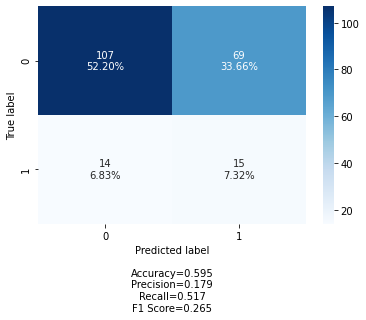

In [82]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

### Refined Architecture

In [180]:
# import torch_geometric.nn as pyg_nn
# import torch_geometric.utils as pyg_utils
from torch_geometric.nn import GCNConv

In [188]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNStack, self).__init__()
        self.curr_dim = hidden_dim
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, self.curr_dim))
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(self.curr_dim))
        for l in range(2):
            old_dim = self.curr_dim
            self.curr_dim = old_dim // 2
            self.convs.append(self.build_conv_model(old_dim, self.curr_dim))
            self.lns.append(nn.LayerNorm(self.curr_dim))
        # post-message-passing (optional)
        self.post_mp = nn.Sequential(
            nn.Linear(self.curr_dim, self.curr_dim), nn.Dropout(0.3), 
            nn.Linear(self.curr_dim, output_dim))

        self.dropout = 0.3
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        return GCNConv(input_dim, hidden_dim)
    
    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index, edge_weight)
#             emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1: # linear xform
                x = self.lns[i](x)

        x = self.post_mp(x)

        return x

In [189]:
model = GNNStack(data.num_node_features, 16, data.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss(weight=normWeights)

In [190]:
writer = SummaryWriter("runs/gnn_" + datetime.now().strftime("%Y%m%d-%H%M%S"))

In [191]:
from sklearn.metrics import precision_score, f1_score

In [192]:
def train(data, writer):
    # train
    for epoch in range(1000):
        model.train()   
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        
        curr_loss = loss.tolist()
        writer.add_scalar("loss", curr_loss, epoch)

        if epoch % 10 == 0:
            test_acc, test_f1 = test(model, is_validation=True)
            print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}. Test F1: {:.4f}".format(
                epoch, curr_loss, test_acc, test_f1))
            writer.add_scalar("test accuracy", test_acc, epoch)
            writer.add_scalar("test_F1", test_f1, epoch)

    return model

In [193]:
def test(model, is_validation=True):
    model.eval()
    correct = 0
    with torch.no_grad():
        pred = model(data)
        pred = pred.cpu().argmax(dim=1)

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = data.y.cpu()[mask]
            
    correct += pred.eq(label).sum().item()
    total = mask.sum()
    
    f1 = f1_score(pred, label)
    return (correct / total), f1

In [194]:
model = train(data, writer)

Epoch 0. Loss: 0.7689. Test accuracy: 0.8585. Test F1: 0.0000
Epoch 10. Loss: 0.7015. Test accuracy: 0.8585. Test F1: 0.0645
Epoch 20. Loss: 0.6967. Test accuracy: 0.1415. Test F1: 0.2479
Epoch 30. Loss: 0.6978. Test accuracy: 0.1415. Test F1: 0.2348
Epoch 40. Loss: 0.6923. Test accuracy: 0.8585. Test F1: 0.0000
Epoch 50. Loss: 0.6932. Test accuracy: 0.8585. Test F1: 0.0000
Epoch 60. Loss: 0.6940. Test accuracy: 0.3073. Test F1: 0.2526
Epoch 70. Loss: 0.6923. Test accuracy: 0.2293. Test F1: 0.2617
Epoch 80. Loss: 0.6923. Test accuracy: 0.8585. Test F1: 0.0000
Epoch 90. Loss: 0.6930. Test accuracy: 0.8390. Test F1: 0.0571
Epoch 100. Loss: 0.6926. Test accuracy: 0.8049. Test F1: 0.0476
Epoch 110. Loss: 0.6937. Test accuracy: 0.7268. Test F1: 0.2432
Epoch 120. Loss: 0.6933. Test accuracy: 0.8585. Test F1: 0.0000
Epoch 130. Loss: 0.6935. Test accuracy: 0.8585. Test F1: 0.0000
Epoch 140. Loss: 0.6930. Test accuracy: 0.8488. Test F1: 0.0606
Epoch 150. Loss: 0.6925. Test accuracy: 0.6293. Tes

In [ ]:
# check tensorboard.

# try different hidden dimensions
# standardising edge weights.
# trying different optimizing schedules, learning rate scheduler, 
# early stopping.
# Try GraphConv, and other layers, pass edge_weights
# different layernorm, different dropouts
# should add lin layers?
